In [48]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD, SlopeOne, KNNBasic, accuracy, BaselineOnly, KNNBaseline, SVDpp
from surprise.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [3]:
# 加载数据
df1 = pd.read_csv('D:/GitHub/netflix/combined_data_1.txt', header=None, names=['user_id', 'rating', 'timestamp'])
df2 = pd.read_csv('D:/GitHub/netflix/combined_data_2.txt', header=None, names=['user_id', 'rating', 'timestamp'])
df3 = pd.read_csv('D:/GitHub/netflix/combined_data_3.txt', header=None, names=['user_id', 'rating', 'timestamp'])
df4 = pd.read_csv('D:/GitHub/netflix/combined_data_4.txt', header=None, names=['user_id', 'rating', 'timestamp'])
if not os.path.exists("D:\code\probe_with_rating.csv"):
    probe = pd.read_csv('D:/GitHub/netflix/probe.txt', header=None, names=['user_id'])

<font color=#FF0000 >**由于数据集合并后再处理的处理时间过长，因此将4个数据集（df1, df2, df3, df4）预处理后再合并成df**</font>

In [4]:
movie_id = 1
# 四个数据集
for i in range(1,5):
    # 通过提取rating为空值的项组成电影id的dataframe
    exec('df%d_movieid = df%d[df%d["rating"].isnull()]' % (i,i,i))
    exec('df%d_movieid.reset_index(inplace=True)' % i)
    # 尝试过将电影id作为新的列合并到数据集df，但运算量巨大；所以用numpy的array导入电影id
    movie_np = []    
    # 将电影id对应的index减去上一个id对应的index再加1就是这部电影的评分数量(j-k-1)
    xx='''
for j,k in zip(df%d_movieid['index'][1:], df%d_movieid['index'][:-1]):
    temp = np.full((1,j-k-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1''' % (i,i)
    exec(xx)
    # for循环没有将最后一部电影的数据加到movie_np当中，因此需要另外加上
    exec('last = np.full((1, len(df%d)-df%d_movieid.iloc[-1]["index"]-1), movie_id)' % (i,i))
    movie_np = np.append(movie_np, last)
    # 下个数据集的第一个电影id
    movie_id += 1
    # 在数据集中去掉电影id的行
    exec('df%d_movieid.set_index(keys="index", inplace=True)' % i)
    exec('df%d.drop(df%d_movieid.index, inplace=True)' % (i,i))
    # 将电影id作为新的一列加到数据集中
    exec('df%d["movie_id"] = movie_np.astype("int")' % i)
    exec('df%d["user_id"] = df%d["user_id"].astype("int")' % (i,i))

In [5]:
df = pd.DataFrame()
df = df.append(df1).append(df2).append(df3).append(df4)
df.reset_index(drop=True, inplace=True)

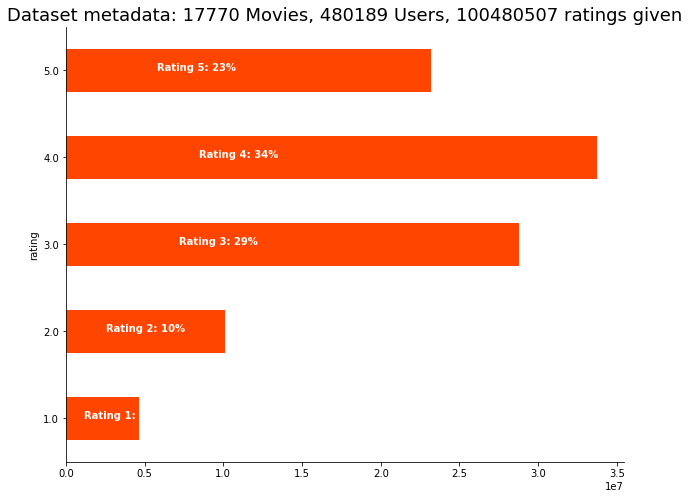

In [6]:
# 评分1-5分的各数量
rating_p = df.groupby('rating')['rating'].agg(['count'])
# 电影数量
movie_num = df['movie_id'].nunique()
# 用户数量
user_num = df['user_id'].nunique()
# 评分的总数量
rating_num = df['rating'].count()
# 画图
ax = rating_p.plot(kind='barh', legend=False, figsize=(10, 8), color='orangered')
plt.title('Dataset metadata: %d Movies, %d Users, %d ratings given' % (movie_num, user_num, rating_num), fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i in range(5):
    ax.text(rating_p.iloc[i][0]/4, i, 'Rating %d: %.0f%%' % (i+1, rating_p.iloc[i]*100/rating_p.sum()[0]), color='white', weight='bold')
plt.show()

<font color=#FF0000 >**处理probe数据集的数据并从df数据集提取评分**</font>

In [7]:
if not os.path.exists("D:\code\probe_with_rating.csv"):
    probe_c = probe.copy()
    # 将movie_id从user_id列中提取出来作为新的一列并将数据中的':'去掉
    movie_col = probe[probe['user_id'].str.contains(':')].copy()
    movie_col['user_id'] = movie_col['user_id'].str.split(':').copy()
    for i in movie_col.index:
        movie_col['user_id'][i] = movie_col['user_id'][i][0]
    probe_c['movie_id'] = movie_col['user_id'].copy()
    # 使用'ffill'方法填充na值
    probe_c.fillna(method='ffill', inplace=True)
    temp = probe[probe['user_id'].str.contains(':')].index.tolist()
    probe_c.drop(probe_c.index[temp], inplace=True)
    probe = probe_c.copy()
    probe['user_id'] = probe['user_id'].astype('int').copy()
    probe['movie_id'] = probe['movie_id'].astype('int').copy()
    del temp, probe_c, movie_col
    # 重置index
    probe.index = list(range(1,len(probe)+1))

    # 从数据集中提取probe的评分
    probe_with_rating = pd.DataFrame()
    for i in range(1, 17771):
        df_m = df[df['movie_id']==i].copy()
        probe_m = probe[probe['movie_id']==i].copy()
        u_list = probe_m['user_id'].tolist()
        m_rating = df_m[df_m['user_id'].isin(u_list)]
        probe_with_rating = pd.concat([probe_with_rating, m_rating])

    # 将结果输出为csv保存，以便下次使用，避免再次长时间处理
    probe_with_rating.to_csv('probe_with_rating.csv')

In [8]:
# 导入保存的带评分的probe数据集
if os.path.exists("D:\code\probe_with_rating.csv"):
    probe_with_rating = pd.read_csv('probe_with_rating.csv')
    probe_with_rating.set_index('Unnamed: 0', inplace=True)
    probe_with_rating.drop('timestamp', axis=1, inplace=True)
    probe_with_rating.columns = ['uid', 'r_ui', 'iid']
    probe_with_rating.insert(1,'iid', probe_with_rating.pop('iid'))
    probe_with_rating.reset_index(drop=True, inplace=True)

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<font color=#FF0000 >**尝试对整个数据集作训练集进行运算，但由于数据集太大内存崩溃，所以对数据集进行精简：将评分数量低于阈值的用户和电影过滤掉**</font>

In [24]:
df_mov_rat_amount = df.groupby('movie_id')['rating'].count()
df_usr_rat_amount = df.groupby('user_id')['rating'].count()
# 评分数量阈值
mov_rat_min_amount = round(df_mov_rat_amount.quantile(0.6), 0)
usr_rat_min_amount = round(df_usr_rat_amount.quantile(0.6), 0)
print('电影最低评分数量：', mov_rat_min_amount, '\n用户最低评分数量：', usr_rat_min_amount)

电影最低评分数量： 1006.0 
用户最低评分数量： 142.0


In [25]:
# 过滤评分数量低于阈值的电影
movie_filter = (df['movie_id'].value_counts() > mov_rat_min_amount)
movie_filter = movie_filter[movie_filter].index.tolist()
# 过滤评分数量低于阈值的用户
user_filter = (df['user_id'].value_counts() > mov_rat_min_amount)
user_filter = user_filter[user_filter].index.tolist()
# 将低于阈值的电影和用户过滤
df_filtered = df[(df['movie_id'].isin(movie_filter)&df['user_id'].isin(user_filter))]
del movie_filter, user_filter, mov_rat_min_amount, usr_rat_min_amount
print('原数据集大小：', df.shape)
print('过滤后数据集大小：', df_filtered.shape)

原数据集大小： (100480507, 4)
过滤后数据集大小： (17472276, 4)


<font color=#FF0000 >**从probe选取在过滤后的数据集仍存在的用户和电影作为测试集**</font>

In [30]:
usr_list = df_filtered['user_id'].unique().tolist()
mov_list = df_filtered['movie_id'].unique().tolist()
testset = probe_with_rating[probe_with_rating['uid'].isin(usr_list)&probe_with_rating['iid'].isin(mov_list)]
print('测试集大小：%d' % len(testset))

测试集大小：34373


<font color=#FF0000 >**--------------------Baseline-als算法--------------------**</font>

In [26]:
reader = Reader(rating_scale=(1, 5))
df_filtered.drop('timestamp', axis=1, inplace=True)
#df_filtered['rating'] = df_filtered['rating'].astype('int')
train_data = Dataset.load_from_df(df_filtered[['user_id', 'movie_id', 'rating']], reader=reader)
train_set = train_data.build_full_trainset()

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:3994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [27]:
bsl_options = {'method': 'als', 'n_epochs': 5, 'reg_u': 12, 'reg_i': 5}
algo = BaselineOnly(bsl_options=bsl_options)
algo.fit(train_set)

Estimating biases using als...


In [29]:
# 计算RMSE
testset_pred = pd.DataFrame(
    [algo.predict(testset['uid'].iloc[i], testset['iid'].iloc[i], testset['r_ui'].iloc[i], verbose=False).est for i in range(len(testset))], 
    columns=['pred'])
y_true = testset['r_ui']
y_pred = testset_pred['pred']
rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
print('Baseline-als RMSE= %.4f' % rmse)

Baseline-als RMSE= 0.8776


<font color=#FF0000 >**--------------------Baseline-sgd算法--------------------**</font>

In [31]:
bsl_options = {'method': 'sgd', 'n_epochs': 5}
algo = BaselineOnly(bsl_options=bsl_options)
algo.fit(train_set)
# 计算RMSE
testset_pred = pd.DataFrame(
    [algo.predict(testset['uid'].iloc[i], testset['iid'].iloc[i], testset['r_ui'].iloc[i], verbose=False).est for i in range(len(testset))], 
    columns=['pred'])
y_true = testset['r_ui']
y_pred = testset_pred['pred']
rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
print('Baseline-als RMSE= %.4f' % rmse)

Estimating biases using sgd...
Baseline-als RMSE= 0.8795


<font color=#FF0000 >**--------------------KNNBaseline-Pearson算法--------------------**</font>

In [38]:
sim_options = {'name':'pearson_baseline', 'user_based':False}
algo = KNNBaseline(sim_options=sim_options)
algo.fit(train_set)
# 计算RMSE
testset_pred = pd.DataFrame(
    [algo.predict(testset['uid'].iloc[i], testset['iid'].iloc[i], testset['r_ui'].iloc[i], verbose=False).est for i in range(len(testset))], 
    columns=['pred'])
y_true = testset['r_ui']
y_pred = testset_pred['pred']
rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
print('KNNBaseline RMSE= %.4f' % rmse)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
KNNBaseline RMSE= 0.6728


<font color=#FF0000 >**--------------------SlopeOne算法--------------------**</font>

In [42]:
algo = SlopeOne()
algo.fit(train_set)
# 计算RMSE
testset_pred = pd.DataFrame(
    [algo.predict(testset['uid'].iloc[i], testset['iid'].iloc[i], testset['r_ui'].iloc[i], verbose=False).est for i in range(len(testset))], 
    columns=['pred'])
y_true = testset['r_ui']
y_pred = testset_pred['pred']
rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
print('SlopeOne RMSE= %.4f' % rmse)

SlopeOne RMSE= 0.8760


<font color=#FF0000 >**--------------------funkSVD算法--------------------**</font>

In [46]:
algo = SVD(biased=False)
algo.fit(train_set)
# 计算RMSE
testset_pred = pd.DataFrame(
    [algo.predict(testset['uid'].iloc[i], testset['iid'].iloc[i], testset['r_ui'].iloc[i], verbose=False).est for i in range(len(testset))], 
    columns=['pred'])
y_true = testset['r_ui']
y_pred = testset_pred['pred']
rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
print('funkSVD RMSE= %.4f' % rmse)

funkSVD RMSE= 0.7253


<font color=#FF0000 >**--------------------biasSVD算法--------------------**</font>

In [47]:
algo = SVD()
algo.fit(train_set)
# 计算RMSE
testset_pred = pd.DataFrame(
    [algo.predict(testset['uid'].iloc[i], testset['iid'].iloc[i], testset['r_ui'].iloc[i], verbose=False).est for i in range(len(testset))], 
    columns=['pred'])
y_true = testset['r_ui']
y_pred = testset_pred['pred']
rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
print('biasSVD RMSE= %.4f' % rmse)

biasSVD RMSE= 0.7213


<font color=#FF0000 >**--------------------SVD++算法--------------------**</font>

In [ ]:
# 耗时太长，没得出结果
algo = SVDpp()
algo.fit(train_set)
# 计算RMSE
testset_pred = pd.DataFrame(
    [algo.predict(testset['uid'].iloc[i], testset['iid'].iloc[i], testset['r_ui'].iloc[i], verbose=False).est for i in range(len(testset))], 
    columns=['pred'])
y_true = testset['r_ui']
y_pred = testset_pred['pred']
rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
print('SVD++ RMSE= %.4f' % rmse)